In [2]:
import pdb,sys,os
import anndata
import scanpy as sc
import argparse
import copy
import numpy as np
from sklearn.cluster import KMeans
import scipy
import faiss
import torch
import sklearn
import scvi
import scSemiProfiler
import gc
import timeit
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.neighbors import kneighbors_graph
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
#from fast_functions import *
from torch.utils.data import Dataset


In [2]:
from scSemiProfiler import initsetup,get_eg_representatives,scprocess,scinfer,activeselect

## Step 1 Initial Setup 
The user provided bulk data is preprocessed, dimensionality reduced, and clustered. \
The sample closest to the cluster centroids are selected as initial representatives.\
*Estimated Time: Less than 1 minute*

In [6]:
name = 'testrun'
bulk = 'example_data/bulkdata.h5ad'
normed = 'yes'
geneselection = 'no'
batch = 2

In [ ]:
initsetup.initsetup(name, bulk,normed,geneselection,batch)

## Step 1.5 Acquiring Single-cell Data for Representatives
The user will sequence the representatives to obtain their actual single-cell data.\
In our example, we offer a function that allows for the extraction of representatives' single-cell data from a pre-prepared dataset.\
*Estimated Time: Less than 1 minute*

In [4]:
get_eg_representatives.get_eg_representatives(name)

## Step 2 Single-cell Processing & Feature Augmentation
In this step, we preprocess the representatives' single-cell data and apply various feature augmentations.\
These enhancements include the addition of gene set scores, aggregation of neighbor cell information, and calculation of gene importance weights.\
*Estimated Time: 2 minutes for each sample with 7000 cells*

In [4]:
scprocess.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed='yes',cellfilter='no',threshold=1e-3,geneset='yes',weight='yes',k=15)

Processing representative single-cell data
Removing background noise
Computing geneset scores
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
Augmenting and saving single-cell data.
Finished processing representative single-cell data


## Step 3 Single-cell Inference
In this step, we employ a VAE-GAN-based deep generative model to infer the single-cell data for each target (non-representative) sample.\
The model training is divided into three distinct stages:\

1. **Pretrain 1**: The model is trained to reconstruct the representatives' single-cell data.

2. **Pretrain 2**: The model continues its reconstruction training in full batch mode, \
now incorporating an additional "representative bulk loss" term in the loss function.\
This term ensures that the reconstructed cells' average expression is similar to pseudobulk.

3. **Inference**: The bulk data difference between the representative and target sample\
is integrated into the generator's reconstruction process through a 'target bulk loss'. \
This guides the generator to accurately infer the target sample's cells.


*Estimated Time for Samples with Approximately 7000 Cells*:
   - Pretrain 1: 15 minutes per sample
   - Pretrain 2: 5 minutes per sample
   - Inference: 30 minutes per sample

In [18]:
name= 'testrun'

In [ ]:
representatives = 'testrun/status/init_representatives.txt'
cluster = 'testrun/status/init_cluster_labels.txt'
targetid = None
bulktype = 'pseudobulk'

scinfer.scinfer(name, representatives,cluster,targetid,bulktype)

Start single-cell inference in cohort mode
pretrain 1: representative reconstruction
load existing pretrain 1 reconstruction model for BGCV09_CV0279


I0000 00:00:1701842245.355163 2958311 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


INFO     Generating sequential column names                                                                        
load existing pretrain 1 reconstruction model for MH9143426
INFO     Generating sequential column names                                                                        
pretrain2: reconstruction with representative bulk loss
load existing model
load existing pretrain 2 model for BGCV09_CV0279
INFO     Generating sequential column names                                                                        
load existing model
load existing pretrain 2 model for MH9143426
INFO     Generating sequential column names                                                                        
inference
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 400/400: 100%|█| 400/400 [08:09<00:00,  1.22s/it, v_num=1, train_loss_

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [08:09<00:00,  1.22s/it, v_num=1, train_loss_


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 400/400: 100%|█| 400/400 [08:07<00:00,  1.21s/it, v_num=1, train_loss_

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [08:07<00:00,  1.22s/it, v_num=1, train_loss_


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 200/200: 100%|█| 200/200 [04:04<00:00,  1.20s/it, v_num=1, train_loss_

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█| 200/200 [04:04<00:00,  1.22s/it, v_num=1, train_loss_


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 200/200: 100%|█| 200/200 [04:01<00:00,  1.19s/it, v_num=1, train_loss_

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█| 200/200 [04:01<00:00,  1.21s/it, v_num=1, train_loss_


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 400/400: 100%|█| 400/400 [07:56<00:00,  1.19s/it, v_num=1, train_loss_

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [07:56<00:00,  1.19s/it, v_num=1, train_loss_
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 342/400:  85%|▊| 341/400 [02:24<00:25,  2.34it/s, v_num=1, train_loss_

## Visualization

In [4]:
# visualizing inference performance for a target sample
def visualize_inferred(name, sids, target, representatives, cluster_labels):
    
    representative = representatives[cluster_labels[target]]
    repredata = anndata.read_h5ad(name + '/sample_sc/'+sids[representative]+'.h5ad')
    x0 = repredata.X
    genelen = x0.shape[1]
    
    xsem = np.load(name + '/inferreddata/' + sids[representative] + '_to_' + sids[target]+'.npy' )
    x1 = xsem[:,:genelen]
    alldata = anndata.read_h5ad('example_data/scdata.h5ad')
    tgtdata = alldata[alldata.obs['sample_ids']==sids[target]]
    x2 = np.array(tgtdata.X.todense())
    x2 = np.exp(x2)-1
    
    vdata = anndata.AnnData(np.concatenate([x0,x1,x2],axis=0))
    rc = []
    for i in range(x0.shape[0]):
        rc.append('Representative')
    for i in range(x1.shape[0]):
        rc.append('Target inferred')
    for i in range(x2.shape[0]):
        rc.append('Target ground truth')
    vdata.obs['recon'] = rc
    sc.pp.log1p(vdata)
    sc.tl.pca(vdata)
    sc.pp.neighbors(vdata)
    sc.tl.umap(vdata)
    
    palette = {'Representative':'blue','Target inferred':'yellow','Target ground truth':'red'}
    sc.pl.umap(vdata,color='recon',alpha=0.5,palette=palette)
    
    return

In [7]:
sids = []
f = open(name + '/sids.txt','r')
lines = f.readlines()
for l in lines:
    sids.append(l.strip())
f.close()

repres = []
f=open(name + '/status/init_representatives.txt','r')
lines = f.readlines()
f.close()
for l in lines:
    repres.append(int(l.strip()))

cl = []
f=open(name + '/status/init_cluster_labels.txt','r')
lines = f.readlines()
f.close()
for l in lines:
    cl.append(int(l.strip()))

Successful inference should generate target cells closer to the target ground truth than to the representative cells.

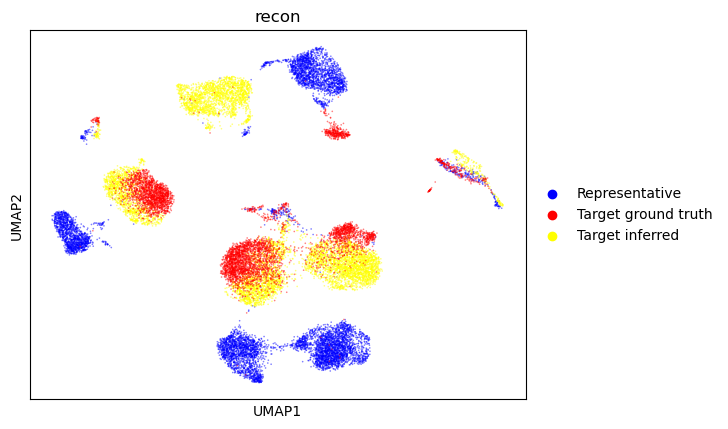

In [8]:
visualize_inferred(name, sids, 0, repres, cl)

## Optional: New Representative Selection and Run the Next Round
You have the option to employ active learning for the selection of additional representatives.\
This approach can result in some target samples having more similar representatives,\
thereby enhancing the accuracy of the inference process.

### select a new batch of representatives using active learning:

In [8]:
representatives = 'testrun/status/init_representatives.txt'
cluster = 'testrun/status/init_cluster_labels.txt'
targetid = None
bulktype = 'pseudobulk'

In [13]:
activeselect.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)

Running active learning to select new representatives
selection finished


### obtain single-cell data for new representatives:

In [14]:
get_eg_representatives.get_eg_representatives(name)

In [15]:
scprocess.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed='yes',cellfilter='no',threshold=1e-3,geneset='yes',weight='yes',k=15)

Processing representative single-cell data
Removing background noise
Computing geneset scores
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
Augmenting and saving single-cell data.
Finished processing representative single-cell data


### run single-cell inference again with more representatives:

In [ ]:
representatives = 'testrun/status/eer_representatives_2.txt'
cluster = 'testrun/status/eer_cluster_labels_2.txt'
targetid = None
bulktype = 'pseudobulk'

scinfer.scinfer(name, representatives, cluster, targetid, bulktype)